**Note:** This notebook contains the complete code used in the accompanying project report on PCA simulations. It is intended as a supplementary resource for reproducibility and validation. For detailed explanations and interpretations, please refer to the written project thesis.

# Large-scale recordings of head direction cells in mouse postsubiculum (Dusziekwicz et al., 2025)

## 1. Load packages and dataset

In [3]:
from dandi.dandiapi import DandiAPIClient
import os
from pynwb import NWBHDF5IO
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.stats import circmean, pearsonr
import cmasher as cmr
from scipy.optimize import minimize
import seaborn as sns

In [4]:
def get_nwb_path(subject_id):
    if os.name == "nt":  # Windows
        base_path = r"C:\Users\emmiw\datasets"
    else:  # Linux/macOS
        username = os.getlogin()
        base_path = f"/home/{username}/datasets"

    nwb_filename = f"sub-{subject_id}_behavior+ecephys.nwb"
    nwb_path = os.path.join(base_path, f"sub-{subject_id}", nwb_filename)
    return nwb_path

In [5]:
subject_id = "A3716"
nwb_path = get_nwb_path(subject_id)

## 2. Extraction of Head-Direction-Spikes

In [6]:
# Spikes der Head-Direction-Cells extrahieren zwischen 3895.81200 Sekunden und 5721.516 Sekunden [wake_square]
def full_hd_spike_extraction(nwb_path, tag='wake_square'):
    io = NWBHDF5IO(nwb_path, mode='r')
    nwbfile = io.read()

    # Head-Direction-Zellen mit Spikes
    hd_indices = np.where(nwbfile.units['is_head_direction'][:])[0]
    hd_spikes = nwbfile.units['spike_times'][hd_indices]

    # Zeitfenster für das Tag
    epochs = nwbfile.intervals['epochs'].to_dataframe()
    row = epochs[epochs['tags'].apply(lambda tags: tag in tags)].iloc[0]
    t0, t1 = row['start_time'], row['stop_time']
    hd_spikes_wake = [spikes[(spikes >= t0) & (spikes <= t1)] for spikes in hd_spikes]

    return hd_spikes_wake, t0, t1, nwbfile

In [7]:
hd_spikes_wake, t0, t1, nwbfile = full_hd_spike_extraction(nwb_path)

c:\Users\emmiw\venvs\jupyter-env\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## 3. Extraction of Head-Direction-Angles

In [8]:
def extract_compass_head_direction(nwbfile, t0, t1, to_degrees=True):
    compass = nwbfile.processing['behavior'].data_interfaces['CompassDirection']
    ts = compass['head-direction']
    times = ts.timestamps[:]
    data = ts.data[:]
    if to_degrees:
        data = np.degrees(data)

    mask = (times >= t0) & (times <= t1)
    hd_times = times[mask]
    hd_angles = data[mask]
    return hd_times, hd_angles

In [9]:
hd_times, hd_angles = extract_compass_head_direction(nwbfile, t0, t1)

## 4. Generate Firingrates with Sliding Window

In [10]:
# für jedes neuron Feuerrate berechnen
def compute_firing_rate(hd_spikes_wake, t0, t1, window_size=0.25, step_size=0.05):
    # startzeitpunkt der Windows
    time_bins = np.arange(t0, t1+step_size, step_size)
    rates = []

    # für jedes Neuron zählt man Anzahl der Spikes in diesem Fenster und teilt durch Fenstergröße
    for spikes in hd_spikes_wake:
        counts = [np.sum((spikes >= t) & (spikes < t + window_size)) / window_size for t in time_bins]
        rates.append(counts)

    rate_matrix = np.array(rates)

    #Glättung
    rate_matrix_smoothed = uniform_filter1d(rate_matrix, size=1, axis=1)

    return rate_matrix_smoothed, time_bins

In [11]:
rate_matrix, time_bins = compute_firing_rate(hd_spikes_wake, t0, t1)

In [12]:
def plot_firing_rates(rate_matrix, time_bins):
    plt.figure(figsize=(12, 6))
    img = plt.imshow(np.clip(rate_matrix, 0, 60), aspect='auto', cmap='inferno',
                     interpolation='nearest', extent=[time_bins[0], time_bins[-1], 0, rate_matrix.shape[0]])
    
    cbar = plt.colorbar(img)
    cbar.set_label('Firing Rate (Hz)', fontsize=18, labelpad=10)  # Labelgröße
    cbar.ax.tick_params(labelsize=18)                # Tickgröße
    
    plt.xlabel('Time (s)', fontsize=18, labelpad=10)
    plt.ylabel('Neuron Index', fontsize=18, labelpad=10)
    plt.yticks(np.arange(0, rate_matrix.shape[0], 10))
    plt.tight_layout()
    plt.tick_params(axis='both', labelsize=18)
    # plt.savefig("../../Latex/figures/8_firingrates_hdneurons.pdf", bbox_inches="tight")
    # plt.savefig("../../Latex/pictures/8_firingrates_hdneurons.png", dpi=400, bbox_inches="tight")
    plt.show()

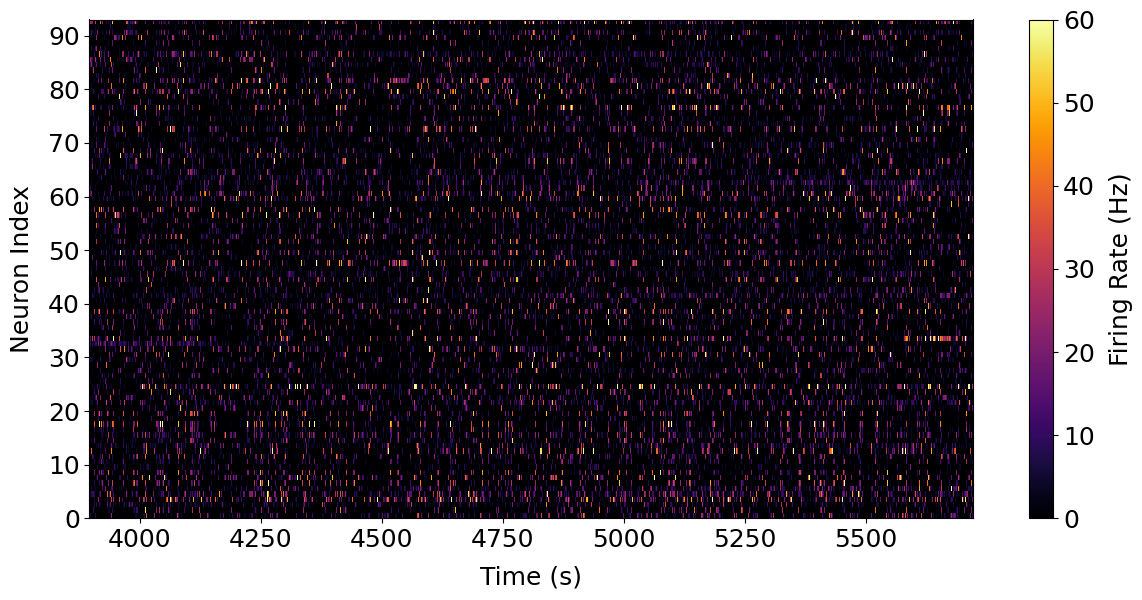

In [13]:
plot_firing_rates(rate_matrix, time_bins)

## 5. Interpolation of Head-Direction-Values

In [14]:
def interpolate_hd_times(hd_times, hd_angles, time_bins):
    # keine NaNs weil sonst Probleme mit np.gradient
    mask = ~np.isnan(hd_angles) & ~np.isnan(hd_times)
    hd_times_valid = hd_times[mask]
    angles_valid = hd_angles[mask]

    # Werte sortieren
    sorted_idx = np.argsort(hd_times_valid)
    hd_times_valid = hd_times_valid[sorted_idx]
    angles_valid = angles_valid[sorted_idx]

    # Winkel wieder auf [-180°, 180°] 
    angles_wrapped = (angles_valid + 180) % 360 - 180

    # Head-Direction-Werte interpolieren auf PCA-Zeitpunkte
    hd_interp_func = interp1d(hd_times_valid, angles_wrapped, bounds_error=False, fill_value="extrapolate")
    hd_angles_interp = hd_interp_func(time_bins)

    hd_angles_interp = (hd_angles_interp + 180) % 360 - 180


    return hd_angles_interp

In [15]:
hd_angles_interp = interpolate_hd_times(hd_times, hd_angles, time_bins)

## 6. PCA with Firing Rate Matrix

### 1. Without Z-Scoring

In [16]:
def pca_without_z(rate_matrix, time_bins):

    # PCA mit so vielen Komponenten wie Neuronen
    pca = PCA(n_components = 3)
    pca.fit(rate_matrix.T)

    # Projektion auf Hauptkomponenten (Zeitpunkte x Komponente)
    transformed = pca.transform(rate_matrix.T)
    
    return pca, transformed

In [17]:
pca_without, transformed_without = pca_without_z(rate_matrix, time_bins)
print("Erklärte Varianz der ersten 3 Hauptkomponenten:\n", pca_without.explained_variance_ratio_)

Erklärte Varianz der ersten 3 Hauptkomponenten:
 [0.12794047 0.11143436 0.0910091 ]


### With axis=0 Z-Scoring

In [18]:
def pca_with_axis_zero(rate_matrix, time_bins):
    # Neuronen normalisieren, damit keine Verzerrungen durch stärkere Zellen kommen
    rate_matrix_z = np.nan_to_num(zscore(rate_matrix, axis=0))

    # PCA mit so vielen Komponenten wie Neuronen
    pca = PCA(n_components = 3)
    pca.fit(rate_matrix_z.T)

    # Projektion auf Hauptkomponenten (Zeitpunkte x Komponente)
    transformed = pca.transform(rate_matrix_z.T)
    
    return pca, transformed, rate_matrix_z

In [19]:
pca_zero, transformed_zero, rate_matrix_z_zero = pca_with_axis_zero(rate_matrix, time_bins)
print("Erklärte Varianz der ersten 3 Hauptkomponenten:\n", pca_zero.explained_variance_ratio_)

Erklärte Varianz der ersten 3 Hauptkomponenten:
 [0.10870116 0.1041196  0.08615794]


### With axis=1 Z-Scoring

In [20]:
def pca_with_axis_one(rate_matrix, time_bins):
    # Neuronen normalisieren, damit keine Verzerrungen durch stärkere Zellen kommen
    rate_matrix_z = np.nan_to_num(zscore(rate_matrix, axis=1))

    # PCA mit so vielen Komponenten wie Neuronen
    pca = PCA(n_components = 3)
    pca.fit(rate_matrix_z.T)

    # Projektion auf Hauptkomponenten (Zeitpunkte x Komponente)
    transformed = pca.transform(rate_matrix_z.T)
    
    return pca, transformed, rate_matrix_z

In [21]:
pca_one, transformed_one, rate_matrix_z_one = pca_with_axis_one(rate_matrix, time_bins)
print("Erklärte Varianz der ersten 3 Hauptkomponenten:\n", pca_one.explained_variance_ratio_)

Erklärte Varianz der ersten 3 Hauptkomponenten:
 [0.10033623 0.08647744 0.06975953]


## 7. Generate Tuning Curves

In [22]:
def compare_tuning_curves(rate_matrices, hd_angles_interp, labels=None, n_neurons=20, nbins=60):

    if labels is None:
        labels = ["Without Z-Scoring", "Z-Scoring (over time)", "Z-Scoring (over neuron)"]

    ylabels = ["Firing Rate [Hz]", "Z-scored Firing Rate \n (over time)", "Z-scored Firing Rate \n (over neuron)"]

    bin_edges = np.linspace(-181, 181, nbins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    rng = np.random.default_rng(42)
    neuron_indices = rng.choice(rate_matrices[0].shape[0], size=n_neurons, replace=False)
    colors = cmr.infinity(np.linspace(0, 1, n_neurons))

    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    # Buchstaben für die Abbildungen
    letters = ['a', 'b', 'c']
    positions = [(0.06, 0.88), (0.06, 0.62), (0.06, 0.35)]  # Position der Buchstaben über den Subplots

    # Buchstaben außerhalb der Subplots platzieren
    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=18, fontweight='bold')



    for ax, rate_matrix, label, ylabel in zip(axes, rate_matrices, labels, ylabels):
        for i, idx in enumerate(neuron_indices):
            fr = rate_matrix[idx]
            bin_means = np.zeros(nbins)
            for b in range(nbins):
                mask = (hd_angles_interp >= bin_edges[b]) & (hd_angles_interp < bin_edges[b+1])
                if np.any(mask):
                    bin_means[b] = np.mean(fr[mask])
            bin_means = uniform_filter1d(np.r_[bin_means[-1], bin_means, bin_means[0]], size=3)[1:-1]
            bin_means = np.r_[bin_means[-1], bin_means, bin_means[0]]
            bin_centers_wrapped = np.r_[-180, bin_centers, 180]
            ax.plot(bin_centers_wrapped, bin_means, color=colors[i], linewidth=1.8)

        ax.set_title(f"{label}", fontsize=14)
        ax.set_ylabel(f"{ylabel}", fontsize=14, labelpad=10)
        ax.set_xlim(-180, 180)
        ax.tick_params(axis='both', labelsize=14)  # Tickgröße

    axes[-1].set_xlabel("Head direction", fontsize=14, labelpad=10)
    axes[-1].set_xticks([-180, -90, 0, 90, 180])
    axes[-1].set_xticklabels(['–180°', '-90°', '0°', '90°', '180°'])

    # Feste y-Achsenlimits und Ticks für Z-scoring-Plots
    y_min = -0.5
    y_max = 3.5
    y_ticks = np.arange(y_min, y_max + 0.01, 0.5)

    for ax in axes[1:]:
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(y_ticks)


    fig.align_ylabels(axes)
    plt.savefig("../../Latex/figures/9_tuning_curves_comparison.pdf", bbox_inches="tight")
    plt.savefig("../../Latex/pictures/9_tuning_curves_comparison.png", dpi=400, bbox_inches="tight")

    plt.show()



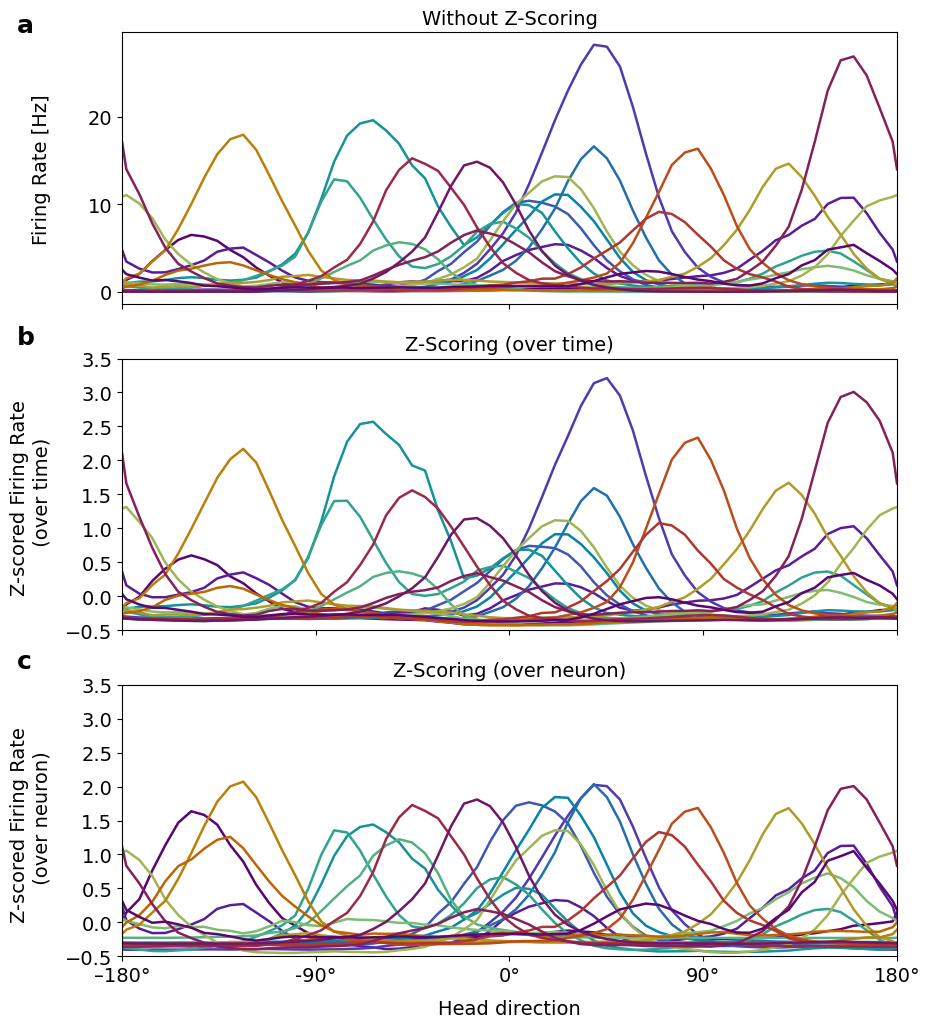

In [23]:
compare_tuning_curves(
    rate_matrices=[rate_matrix, rate_matrix_z_zero, rate_matrix_z_one],
    hd_angles_interp=hd_angles_interp
)


## 8. Sine + Cosine Decoder

In [24]:
def sincos_decoder(p, hd_angles_deg):
    # Normen der PCA-Punkte
    p_norms = np.linalg.norm(p, axis=1)

    # Zielwerte berechnen
    theta_rad = np.radians(hd_angles_deg)
    b_cos = p_norms * np.cos(theta_rad)
    b_sin = p_norms * np.sin(theta_rad)

    # Loss-Funktion für cos
    def loss_cos(r):
        r = r / np.linalg.norm(r)
        return np.sum((p @ r - b_cos) ** 2)

    # Loss-Funktion für sin
    def loss_sin(r):
        r = r / np.linalg.norm(r)
        return np.sum((p @ r - b_sin) ** 2)

    # Startwert
    r0 = np.random.randn(3)

    # Optimierung
    result_cos = minimize(loss_cos, r0, method='BFGS')
    result_sin = minimize(loss_sin, r0, method='BFGS')

    # Rückgabe: beide normierten Richtungsvektoren
    r_cos = result_cos.x / np.linalg.norm(result_cos.x)
    r_sin = result_sin.x / np.linalg.norm(result_sin.x)

    # Dekodierte Head-Direction-Winkel
    x_proj = p @ r_cos
    y_proj = p @ r_sin
    theta_rad = np.arctan2(y_proj, x_proj)
    sincos_angles = np.degrees(theta_rad)

    return r_cos, r_sin, sincos_angles

### Without Z-Scoring

In [25]:
r_cos_without, r_sin_without, sincos_angles_without = sincos_decoder(transformed_without, hd_angles_interp)

### Z-Scoring axis=0

In [26]:
r_cos_zero, r_sin_zero, sincos_angles_zero = sincos_decoder(transformed_zero, hd_angles_interp)

### Z-Scoring axis=1

In [27]:
r_cos_one, r_sin_one, sincos_angles_one = sincos_decoder(transformed_one, hd_angles_interp)

## Decoder: Comparison

In [28]:
def plot_sincos_comparison_grid(transformed_list, hd_angles_list, decoded_angles_list, titles):
    fig = plt.figure(figsize=(18, 10), constrained_layout=True)


    # Buchstaben für die Abbildungen
    letters = ['a', 'b', 'c', 'd', 'e', 'f']
    positions = [(0.11, 0.97), (1.00, 0.97), (1.89, 0.97), (0.11, 0.46), (1.0, 0.46), (1.89, 0.46)]  # Position der Buchstaben über den Subplots

    # Buchstaben außerhalb der Subplots platzieren
    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=20, fontweight='bold')

    axs = fig.subplots(2, 3, subplot_kw={'projection': '3d'})
    cmap = 'cmr.infinity'
    scatter_handles = []

    for i in range(3):
        # Oben: Gegebene Head Direction
        sc1 = axs[0, i].scatter(
            transformed_list[i][:, 0],
            transformed_list[i][:, 1],
            transformed_list[i][:, 2],
            c=hd_angles_list[i], cmap=cmap, s=1
        )
        axs[0, i].set_title(f"{titles[i]}\n(original)", fontsize="18")
        axs[0, i].set_xlabel("PC1", fontsize="16", labelpad=10)
        axs[0, i].set_ylabel("PC2", fontsize="16", labelpad=10)
        axs[0, i].set_zlabel("PC3", fontsize="16", labelpad=10)
        axs[0, i].tick_params(axis='both', labelsize=14)
        scatter_handles.append(sc1)

        # Unten: Dekodierte Head Direction
        sc2 = axs[1, i].scatter(
            transformed_list[i][:, 0],
            transformed_list[i][:, 1],
            transformed_list[i][:, 2],
            c=decoded_angles_list[i], cmap=cmap, s=1
        )
        axs[1, i].set_title(f"(decoded)", fontsize="18")
        axs[1, i].set_xlabel("PC1", fontsize="16", labelpad=10)
        axs[1, i].set_ylabel("PC2", fontsize="16", labelpad=10)
        axs[1, i].set_zlabel("PC3", fontsize="16", labelpad=10)
        axs[1, i].tick_params(axis='both', labelsize=14)
        scatter_handles.append(sc2)

    # Gemeinsame Colorbar
    cbar = plt.colorbar(scatter_handles[0], ax=axs, location='right', shrink=1)
    cbar.set_ticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    cbar.set_ticklabels([
        r"$-180^\circ$", r"$-135^\circ$", r"$-90^\circ$", r"$-45^\circ$",
        r"$0^\circ$",
        r"$45^\circ$", r"$90^\circ$", r"$135^\circ$", r"$180^\circ$"
    ])
    cbar.set_label('Head Direction (°)', fontsize=22, labelpad=10)  # Labelgröße
    cbar.ax.tick_params(labelsize=20)   
    
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.15, hspace=0.06)
    plt.savefig("../../Latex/figures/10_decoder_original_comparison.pdf", bbox_inches="tight")
    plt.savefig("../../Latex/pictures/10_decoder_original_comparison.png", dpi=500, bbox_inches="tight")
    
    plt.show()


In [29]:
# plot_sincos_comparison_grid(
#     transformed_list=[transformed_without, transformed_zero, transformed_one],
#     hd_angles_list=[hd_angles_interp]*3,
#     decoded_angles_list=[sincos_angles_without, sincos_angles_zero, sincos_angles_one],
#     titles=["Unstandardised", "Z-Scoring over time", "Z-Scoring over neuron"]
# )


C:\Users\emmiw\AppData\Local\Temp\ipykernel_3536\517472108.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


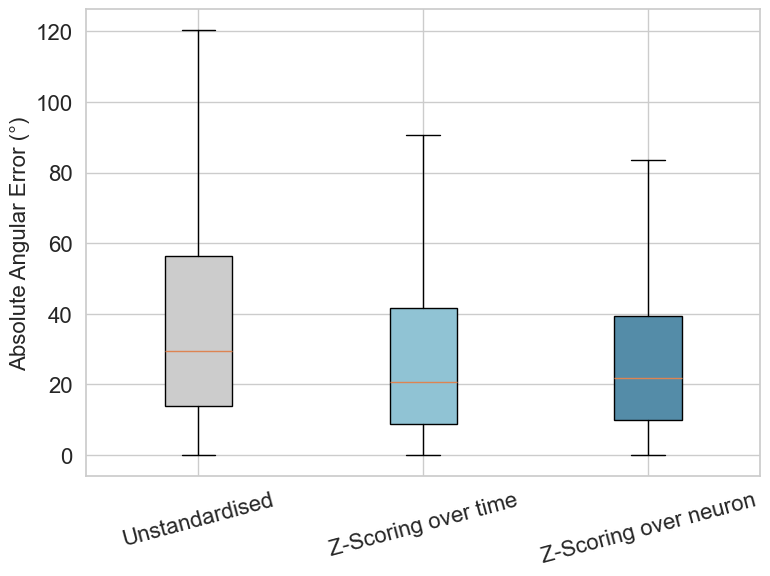

In [38]:
# Fehler berechnen (pro Zeitpunkt)
def angular_difference_deg(true_deg, pred_deg):
    return (true_deg - pred_deg + 180) % 360 - 180

diffs_no = np.abs(angular_difference_deg(hd_angles_interp, sincos_angles_without))
diffs_0 = np.abs(angular_difference_deg(hd_angles_interp, sincos_angles_zero))
diffs_1 = np.abs(angular_difference_deg(hd_angles_interp, sincos_angles_one))

# Plot-Stil
sns.set(style="whitegrid", font_scale=1.2)

# Plot
plt.figure(figsize=(8, 6))
box = plt.boxplot(
    [diffs_no, diffs_0, diffs_1],
    labels=["Unstandardised", "Z-Scoring over time", "Z-Scoring over neuron"],
    patch_artist=True,
    showfliers=False  # Ausreißer ausblenden für Klarheit
)

# Farben setzen
colors = ["#cccccc", "#90c3d4", "#548ca8"]
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

plt.ylabel("Absolute Angular Error (°)", size=16)
# plt.title("Decoder Error Comparison with/without Z-Scoring")
plt.xticks(rotation=15, size=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.ylim(0, 130)
plt.savefig("../../Latex/figures/11_boxplot.pdf", bbox_inches="tight")
plt.savefig("../../Latex/pictures/11_boxplot.png", dpi=300, bbox_inches="tight")
    
plt.show()


### Balkendiagramm Explained Variance Ratio

In [ ]:
def plot_explained_variance_bar_from_models(pca_without, pca_zero, pca_one):
    evr_dict = {
        'raw': pca_without.explained_variance_ratio_[:3],
        'axis0': pca_zero.explained_variance_ratio_[:3],
        'axis1': pca_one.explained_variance_ratio_[:3]
    }

    preprocessing_methods = ['raw', 'axis0', 'axis1']
    colors = ["#cccccc", "#90c3d4", "#548ca8"]
    pcs = ['PC1', 'PC2', 'PC3']
    x = np.arange(len(pcs))  # Positionen für PC1, PC2, PC3
    width = 0.25  # Breite der Balken

    fig, ax = plt.subplots(figsize=(8, 5))

    for i, (method, color) in enumerate(zip(preprocessing_methods, colors)):
        evrs = evr_dict[method]
        ax.bar(x + i * width - width, evrs, width, label=method, color=color)

    ax.set_ylabel('Explained Variance Ratio', size=16)
    ax.set_xticks(x)
    ax.set_xticklabels(pcs, size=16)
    ax.tick_params(labelsize=16)
    plt.legend(preprocessing_methods, fontsize=16)

    plt.savefig("../../Latex/figures/12_evr_comparison.pdf", bbox_inches="tight")
    plt.savefig("../../Latex/pictures/12_evr_comparison.png", dpi=300, bbox_inches="tight")
   

    plt.tight_layout()
    plt.show()



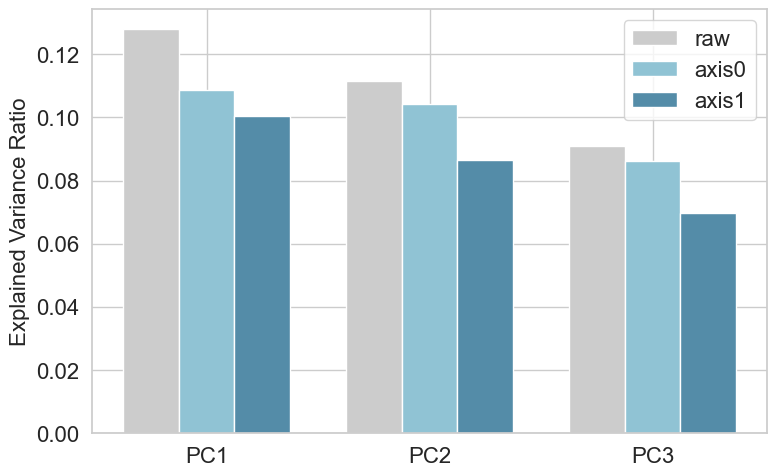

In [32]:
plot_explained_variance_bar_from_models(pca_without, pca_zero, pca_one)


## 3x3 Subplot mit original, decoder und winkelfehler

In [ ]:
def plot_sincos_comparison_error(transformed_list, hd_angles_list, decoded_angles_list, titles, r_cos_list=None, r_sin_list=None):
    fig = plt.figure(figsize=(18, 15), constrained_layout=True)

    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
    positions = [
        (0.15, 0.97), (1.15, 0.97), (2.15, 0.97),
        (0.15, 0.63), (1.15, 0.63), (2.15, 0.63),
        (0.15, 0.29), (1.15, 0.29), (2.15, 0.29)
    ]

    for letter, (xpos, ypos) in zip(letters, positions):
        fig.text(xpos / 3, ypos, letter, fontsize=26, fontweight='bold')

    axs = fig.subplots(3, 3, subplot_kw={'projection': '3d'})

    cmap_hd = 'cmr.infinity'
    cmap_error = 'PiYG'

    for i in range(3):
        # Zeile 1: Original
        axs[0, i].scatter(
            transformed_list[i][:, 0],
            transformed_list[i][:, 1],
            transformed_list[i][:, 2],
            c=hd_angles_list[i], cmap=cmap_hd, s=1
        )
        axs[0, i].set_title(f"{titles[i]}\n(original)", fontsize="24")

        # Zeile 2: Decoded
        axs[1, i].scatter(
            transformed_list[i][:, 0],
            transformed_list[i][:, 1],
            transformed_list[i][:, 2],
            c=decoded_angles_list[i], cmap=cmap_hd, s=1
        )
        axs[1, i].set_title(f"(decoded)", fontsize="24")

        # Vektoren hinzufügen
        # Unstandardised

        # axs[1, 0] – Unstandardised
        center = np.mean(transformed_without, axis=0)
        scale = 100.0

        axs[1, 0].quiver(*center, *(r_cos_list[0] / np.linalg.norm(r_cos_list[0])) * scale,
                        color='red', linewidth=2, label='r_cos')
        axs[1, 0].quiver(*center, *(r_sin_list[0] / np.linalg.norm(r_sin_list[0])) * scale,
                        color='blue', linewidth=2, label='r_sin')

        handles, labels = axs[1, 0].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[1, 0].legend(by_label.values(), by_label.keys(), fontsize=18)

        # axs[1, 1] – Z-Scoring over time
        center = np.mean(transformed_zero, axis=0)
        scale = 8.0

        axs[1, 1].quiver(*center, *(r_cos_list[1] / np.linalg.norm(r_cos_list[1])) * scale,
                        color='red', linewidth=2)
        axs[1, 1].quiver(*center, *(r_sin_list[1] / np.linalg.norm(r_sin_list[1])) * scale,
                        color='blue', linewidth=2)

        # axs[1, 2] – Z-Scoring over neuron
        center = np.mean(transformed_one, axis=0)
        scale = 12.0

        axs[1, 2].quiver(*center, *(r_cos_list[2] / np.linalg.norm(r_cos_list[2])) * scale,
                        color='red', linewidth=2)
        axs[1, 2].quiver(*center, *(r_sin_list[2] / np.linalg.norm(r_sin_list[2])) * scale,
                        color='blue', linewidth=2)

        # Zeile 3: Fehler
        angle_error = angular_difference_deg(hd_angles_list[i], decoded_angles_list[i])
        axs[2, i].scatter(
            transformed_list[i][:, 0],
            transformed_list[i][:, 1],
            transformed_list[i][:, 2],
            c=angle_error, cmap='PiYG', s=1, norm=plt.Normalize(vmin=-180, vmax=180)
        )
        axs[2, i].set_title(f"(error)", fontsize="24")

        for row in range(3):
            axs[row, i].set_xlabel("PC1", fontsize="20", labelpad=12)
            axs[row, i].set_ylabel("PC2", fontsize="20", labelpad=12)
            axs[row, i].set_zlabel("PC3", fontsize="20", labelpad=12)
            axs[row, i].tick_params(axis='both', labelsize=20)

    # Colorbars
    cbar_ax_hd = fig.add_axes([1, 0.35, 0.015, 0.60])
    sm_hd = cm.ScalarMappable(cmap=cmap_hd, norm=plt.Normalize(vmin=-180, vmax=180))
    sm_hd.set_array([])
    cbar_hd = fig.colorbar(sm_hd, cax=cbar_ax_hd)
    cbar_hd.set_label('Head Direction (°)', fontsize=28, labelpad=15)
    cbar_hd.set_ticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    cbar_hd.set_ticklabels([
        r"$-180^\circ$", r"$-135^\circ$", r"$-90^\circ$", r"$-45^\circ$",
        r"$0^\circ$",
        r"$45^\circ$", r"$90^\circ$", r"$135^\circ$", r"$180^\circ$"
    ])
    cbar_hd.ax.tick_params(labelsize=24)

    cbar_ax_err = fig.add_axes([1, 0.04, 0.015, 0.25])
    sm_err = cm.ScalarMappable(cmap='PiYG', norm=plt.Normalize(vmin=-180, vmax=180))
    sm_err.set_array([])
    cbar_err = fig.colorbar(sm_err, cax=cbar_ax_err)
    cbar_err.set_label('Signed Angular Error (°)', fontsize=28, labelpad=15)
    cbar_err.set_ticks([-180, -90, 0, 90, 180])
    cbar_err.set_ticklabels([
        r"$-180^\circ$", r"$-90^\circ$", r"$0^\circ$", r"$90^\circ$", r"$180^\circ$"
    ])
    cbar_err.ax.tick_params(labelsize=24)

    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.15, hspace=0.08)
    plt.savefig("../../Latex/figures/14_decoder_original_comparison_error.pdf", bbox_inches="tight")
    plt.savefig("../../Latex/pictures/14_decoder_original_comparison_error.png", dpi=500, bbox_inches="tight")
    plt.show()


C:\Users\emmiw\AppData\Local\Temp\ipykernel_3536\2679390404.py:117: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.15, hspace=0.08)


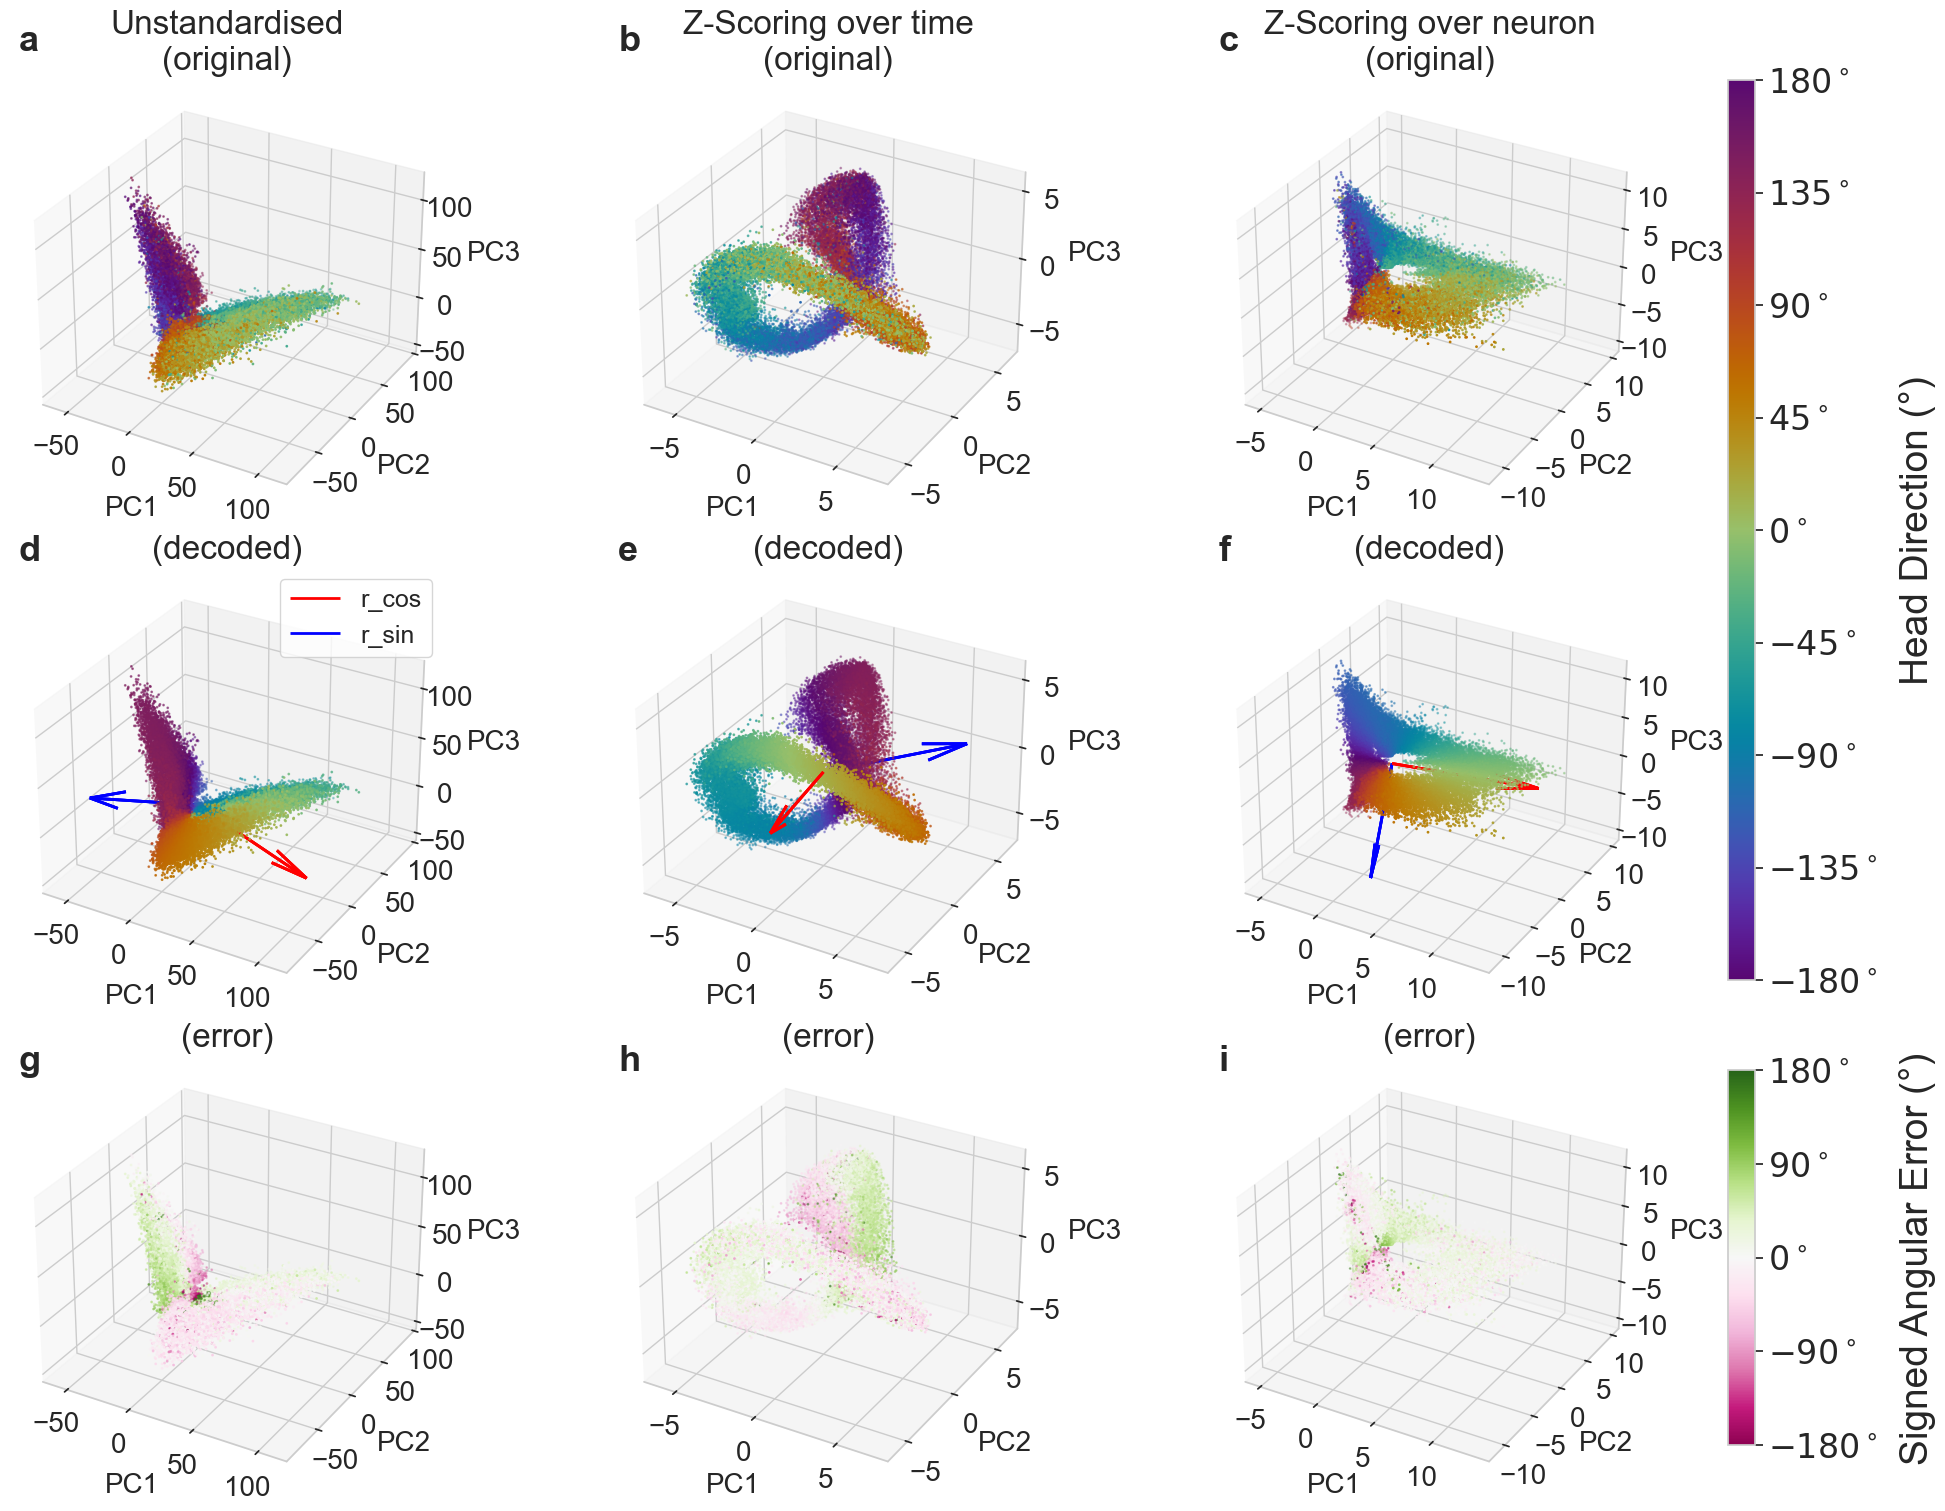

In [ ]:
r_cos_list = []
r_sin_list = []

for p in [transformed_without, transformed_zero, transformed_one]:
    r_cos, r_sin, _ = sincos_decoder(p, hd_angles_interp) 
    r_cos_list.append(r_cos)
    r_sin_list.append(r_sin)


plot_sincos_comparison_error(
    transformed_list=[transformed_without, transformed_zero, transformed_one],
    hd_angles_list=[hd_angles_interp]*3,
    decoded_angles_list=[sincos_angles_without, sincos_angles_zero, sincos_angles_one],
    titles=["Unstandardised", "Z-Scoring over time", "Z-Scoring over neuron"],
    r_cos_list=r_cos_list,
    r_sin_list=r_sin_list
)

